# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from IPython.display import Image
from IPython.display import display

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


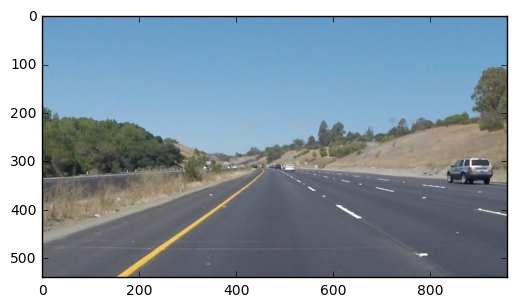

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#return lines for final picture overlay 
def pic_overlay(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    slopes = {}
    slopes['neg'] = []
    slopes['pos'] = []
    #slopes['neg_slope'] = []
    #slopes['pos_slope'] = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            #find slope and add to dict, if slope is negative add to right or if positive left line
            if (y2-y1) != 0 and (x2-x1) !=0:
                slope = (y2-y1)/(x2-x1)
                if slope > 0.2 and slope < 2:
                    slopes['neg'].append([x1,y1,x2,y2])
                    #slopes['neg_slope'].append(slope)
                elif slope < -0.2 and slope >-2:
                    slopes['pos'].append([x1,y1,x2, y2])
                    #slopes['pos_slope'].append(slope)
                
    #calculate the slope for the left and right lanes
    #pos_slope = np.asarray(slopes['pos_slope']).mean(0)
    #neg_slope = np.asarray(slopes['neg_slope']).mean(0)

    ##################Using polyfit line########################
    #####pos slope
    if len(slopes['pos']) > 0:
        pos_xh = [x[0] for x in slopes['pos']]
        pos_yh = [y[1] for y in slopes['pos']]
        pos_slope, pos_b = np.polyfit(pos_xh, pos_yh, 1) 
    else:
        pos_slope, pos_b = 0, 0
    
    #####neg slope
    if len(slopes['neg'])>0:
        neg_xh = [xx[2] for xx in slopes['neg']]
        neg_yh = [yy[3] for yy in slopes['neg']]
        neg_slope, neg_b = np.polyfit(neg_xh, neg_yh, 1)
    else:
        neg_slope, neg_b = 0, 0
    ############################################################
    
    #Line for regression
    Y1 = img.shape[0]
    Y2 = 330

    if pos_slope!=0 and neg_slope!=0:
        #for right lane
        X12 = int((Y1-pos_b)/pos_slope)
        X22 = int((Y2-pos_b)/pos_slope)
        #for left lane
        X1 = int((Y1-neg_b)/neg_slope)
        X2 = int((Y2-neg_b)/neg_slope)
    else:
        X12 = 0
        X22 = 0
        X1 = 0
        X2 = 0
  
    #Stop integer overflow in video stream
    #left lane
    if abs(X1) > 2*img.shape[1] and X1>0: 
        X1 = 2*img.shape[1] 
    elif abs(X1) > 2*img.shape[1] and X1<0: 
        X1 = -2*img.shape[1]
    
    if abs(X2) > 2*img.shape[1] and X2>0: 
        X2 = 2*img.shape[1] 
    elif abs(X2) > 2*img.shape[1] and X2<0: 
        X2 = -2*img.shape[1]
        
    #right lane
    if abs(X12) > 2*img.shape[1] and X12>0: 
        X12 = 2*img.shape[1] 
    elif abs(X12) > 2*img.shape[1] and X12<0: 
        X12 = -2*img.shape[1]
    
    if abs(X22) > 2*img.shape[1] and X22>0: 
        X22 = 2*img.shape[1] 
    elif abs(X22) > 2*img.shape[1] and X22<0: 
        X22 = -2*img.shape[1]
        
    #blank image shape    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #left lane
    cv2.line(line_img, (X12, Y1), (X22, Y2), color=[255, 0, 0],thickness=10)
    #right lane
    cv2.line(line_img, (X1, Y1), (X2, Y2), color=[255, 0, 0],thickness=10)
    
    #print([X1, X2, X12, X22])
    return line_img

def color_filter(img):
    '''Takes in an image and returns only yellow and white regions only using hsv filters'''
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([190,255,255])

    lower_white = np.array([0, 0, 130])
    upper_white = np.array([70, 70, 255]) 
     
    #Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow) # I have the Green threshold image.
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    mask = yellow_mask + white_mask

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)
    #plt.imshow(grayscale(res), cmap = 'gray')
    
    return res
    

In [4]:
#Find colors for HSV filter
#[H-10, 100,100] and [H+10, 255, 255]
white = np.uint8([[[255,255,255]]])
hsv_white = cv2.cvtColor(white,cv2.COLOR_BGR2HSV)
print(hsv_white)

yellow = np.uint8([[[255,255,0]]])
hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
print(hsv_yellow)

[[[  0   0 255]]]
[[[ 90 255 255]]]


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

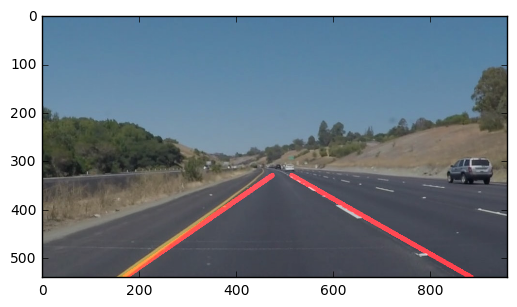

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import numpy as np
#reading in image
image0 = mpimg.imread('test_images/solidWhiteRight.jpg')
image1 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image2 = mpimg.imread('test_images/solidYellowCurve.jpg') 
image3 = mpimg.imread('test_images/solidWhiteRight.jpg')
image4 = mpimg.imread('test_images/solidYellowCurve2.jpg') 
image5 = mpimg.imread('test_images/solidYellowLeft.jpg') 
#apply color filter for white and yellow lines
img = color_filter(image1)
#greyscale image
gray = grayscale(img)
#plt.imshow(gray, cmap = 'gray')
#histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

#apply Gaussian blur
gaus_gray = gaussian_blur(cl1, 3)

#apply canny edge detection
can_gray = canny(gaus_gray, low_threshold=50, high_threshold=100)

#plt.imshow(can_gray, cmap = 'gray')
#apply image segmentation
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 340), (490, 340), (imshape[1],imshape[0])]], dtype=np.int32)
reg_gray = region_of_interest(can_gray, vertices = vertices)

#apply image augmentation
lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=3, min_line_len=5, max_line_gap=1)

#apply line extrapolation on hough_coord
draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)

plt.imsave('whiteCarLaneSwitch_with_lanes.jpg', draw_lanes)
plt.imshow(draw_lanes)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
import imageio
imageio.plugins.ffmpeg.download()

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    #pipeline
    #gray scale -> histogram equalization ->gaussian blur -> canny detection -> ROI -> Hough -> Lane drawing
    
    #apply color filter for white and yellow lines
    img = color_filter(image)
    
    #greyscale image
    gray = grayscale(img)
    #plt.imshow(gray, cmap = 'gray')
    
    #histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #apply Gaussian blur
    gaus_gray = gaussian_blur(cl1, 7)

    #apply canny edge detection
    can_gray = canny(gaus_gray, low_threshold=100, high_threshold=150)

    #plt.imshow(can_gray, cmap = 'gray')
    #apply image segmentation
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 300), (490, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    reg_gray = region_of_interest(can_gray, vertices = vertices)

    #apply image augmentation
    lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=1, min_line_len=9, max_line_gap=1)

    #apply line extrapolation on hough_coord
    draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)
    return draw_lanes

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:21<00:00,  7.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 37.8 s, sys: 2.29 s, total: 40.1 s
Wall time: 22.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:13<00:00, 10.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min, sys: 5.98 s, total: 2min 6s
Wall time: 1min 14s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


There are a couple of things I could've done to improve the results:
    1. optimize all the different algorithms:
    I found it difficult to optimize all the different parameters to generalize all the different lighting conditions. Perhaps this would've stopped some of the dramatic dotted lane jumps.
    2. Find an adequate color picker to help make an effective color mask to separate white and yellow hues
    3. Use a frame buffer to stop the jittery lane overalays - however this could be done at a later stage in the pipeline whilst considering other factors/sensory data.
    4. Due to starting on Dec 14th - aka the start of my holiday and travels, perhaps I would've had more time to pursue the challenge video optimization part of the project
All in all this was an interesting project and taught me how to fine tune and troubleshoot different opencv packages.